<a href="https://colab.research.google.com/github/jiananwu72/Defect-Detection/blob/main/AtomAIDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/pycroscopy/atomai # install the latest version from source
!pip install -q pyNSID sidpy SciFiReaders wget
!pip install numpy==1.26.4

  Cloning https://github.com/pycroscopy/atomai to /tmp/pip-req-build-zlhhk868
  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/atomai /tmp/pip-req-build-zlhhk868
  Resolved https://github.com/pycroscopy/atomai to commit 8db3e944cd9ece68c33c8e3fcca3ef3ce9a111ea
  Preparing metadata (setup.py) ... done


In [2]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt

In [3]:
download_link1 = 'https://drive.google.com/uc?id=1-4-IQ71m--OelQb1891GnbG1Ako1-DKh'
download_link2 = 'https://drive.google.com/uc?id=18JK9GcMPMWHmHtwArujVQRLr6N4VIM_j'
!gdown -q $download_link1 -O 'training_data.npy'
!gdown -q $download_link2 -O 'validation_data.npy'

# Load train/test data (this is a simple dataset generated just from a single image)
dataset = np.load('training_data.npy')
images = dataset['X_train']
labels = dataset['y_train']
images_test = dataset['X_test']
labels_test = dataset['y_test']
# Load validation data (data from different experiment)
# expdata = np.load("validation_data.npy")

In [4]:
print(images.shape, labels.shape)
print(images_test.shape, labels_test.shape)

(1656, 1, 256, 256) (1656, 256, 256)
(414, 1, 256, 256) (414, 256, 256)


##Training Data

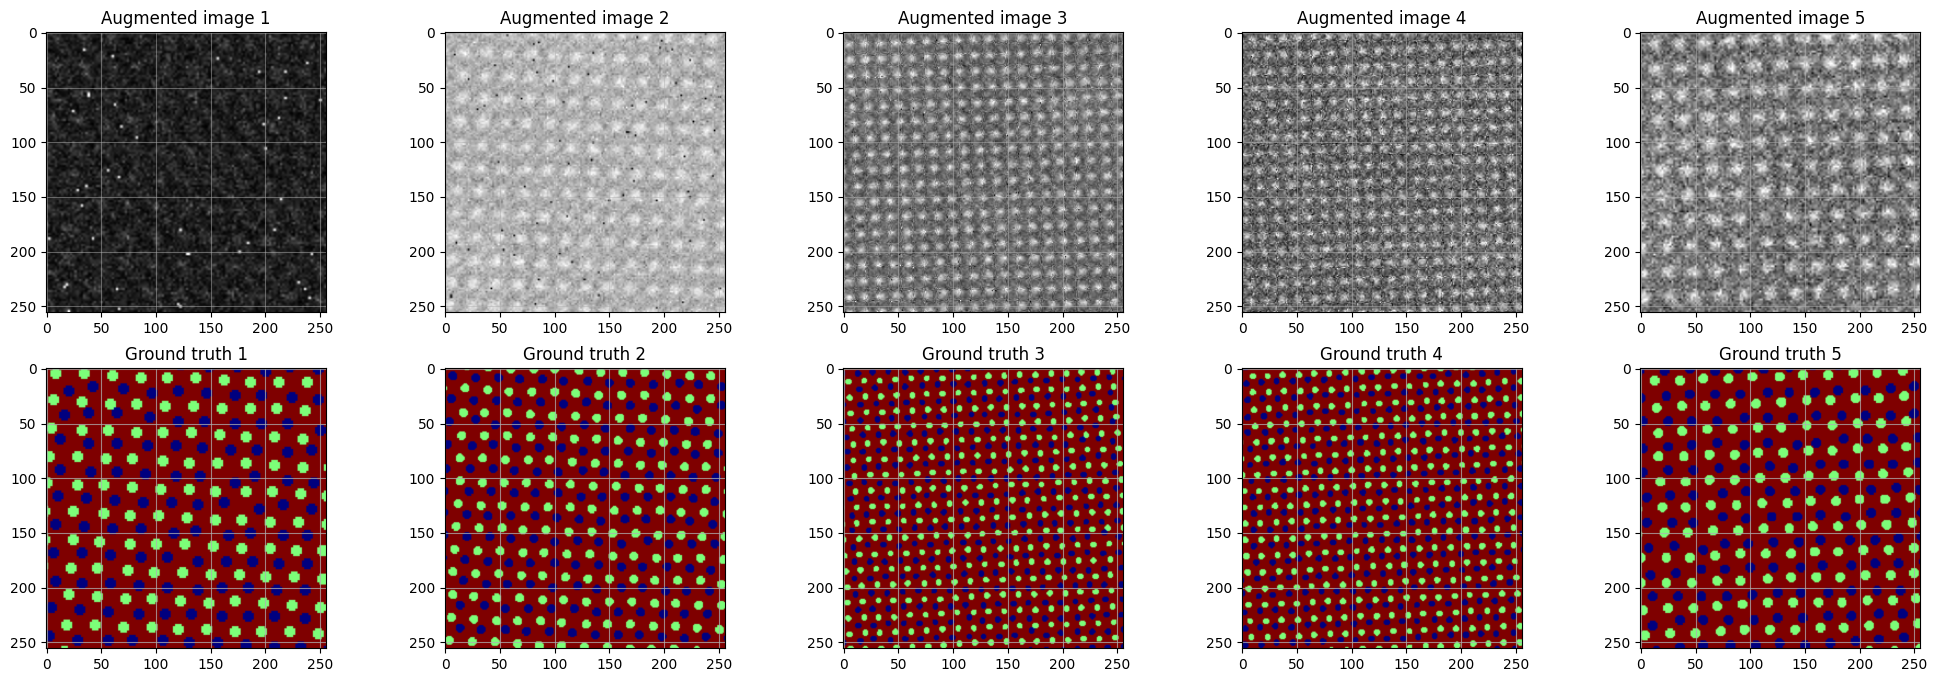

In [5]:
n = 5 # number of images to plot
k = 0 #starting point

n = n + 1
fig = plt.figure( figsize=(30, 8))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i+k-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i+k))
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(labels[i+k-1], interpolation='Gaussian', cmap='jet')
    ax.set_title('Ground truth ' + str(i+k))
    ax.grid(alpha=0.75)

In [6]:
model = aoi.models.Segmentor(nb_classes=3)
print(model.net)

Unet(
  (c1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c3): ConvBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

Epoch 1/300 ... Training loss: 1.2846 ... Test loss: 1.2103 ... Train Accuracy: 0.0901 ... Test Accuracy: 0.0405 ... GPU memory usage: 6172/15360
Epoch 100/300 ... Training loss: 0.4576 ... Test loss: 0.3881 ... Train Accuracy: 0.6666 ... Test Accuracy: 0.6646 ... GPU memory usage: 7038/15360
Epoch 200/300 ... Training loss: 0.2796 ... Test loss: 0.2632 ... Train Accuracy: 0.7267 ... Test Accuracy: 0.7339 ... GPU memory usage: 7038/15360
Epoch 300/300 ... Training loss: 0.2317 ... Test loss: 0.2242 ... Train Accuracy: 0.742 ... Test Accuracy: 0.7386 ... GPU memory usage: 7038/15360
Model (final state) evaluation loss: 0.2384
Model (final state) accuracy: 0.7207
Performing stochastic weight averaging...
Model (final state) evaluation loss: 0.2295
Model (final state) accuracy: 0.7289
Plotting training history


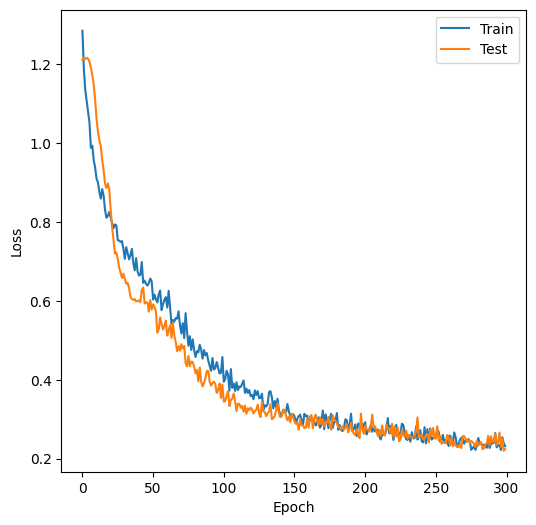

In [7]:
model.fit(images, labels, images_test, labels_test, # training data
          training_cycles=300, compute_accuracy=True, swa=True # training parameters
)

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.


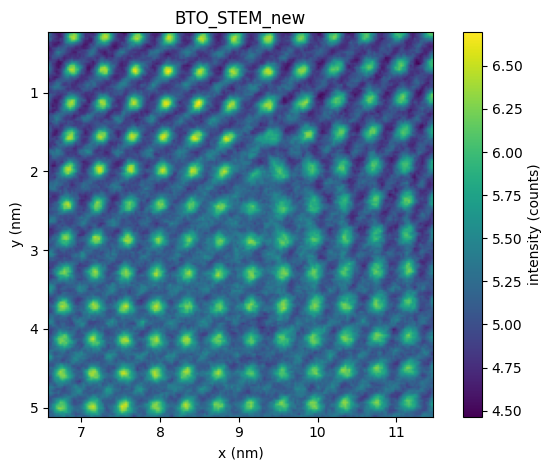

In [8]:
import wget
import SciFiReaders as sr
wget.download(url='https://zenodo.org/record/8190744/files/bto_atomic.dm3?download=1',
              out = 'bto_atomic.dm3')

dm3_file = r'bto_atomic.dm3'
dm3_reader = sr.DM3Reader(dm3_file)
dataset = dm3_reader.read()["Channel_000"]
dataset.title = 'BTO_STEM'
dataset._axes[0].quantity = 'x'
dataset._axes[1].quantity = 'y'
# dataset = dataset[700:900,150:350]

dataset = dataset[270:470,10:210]
expdata = np.array(dataset)
dataset.plot();

In [9]:
nn_output, coordinates = model.predict(expdata)

Batch 1/1
1 image was decoded in approximately 0.0242 seconds


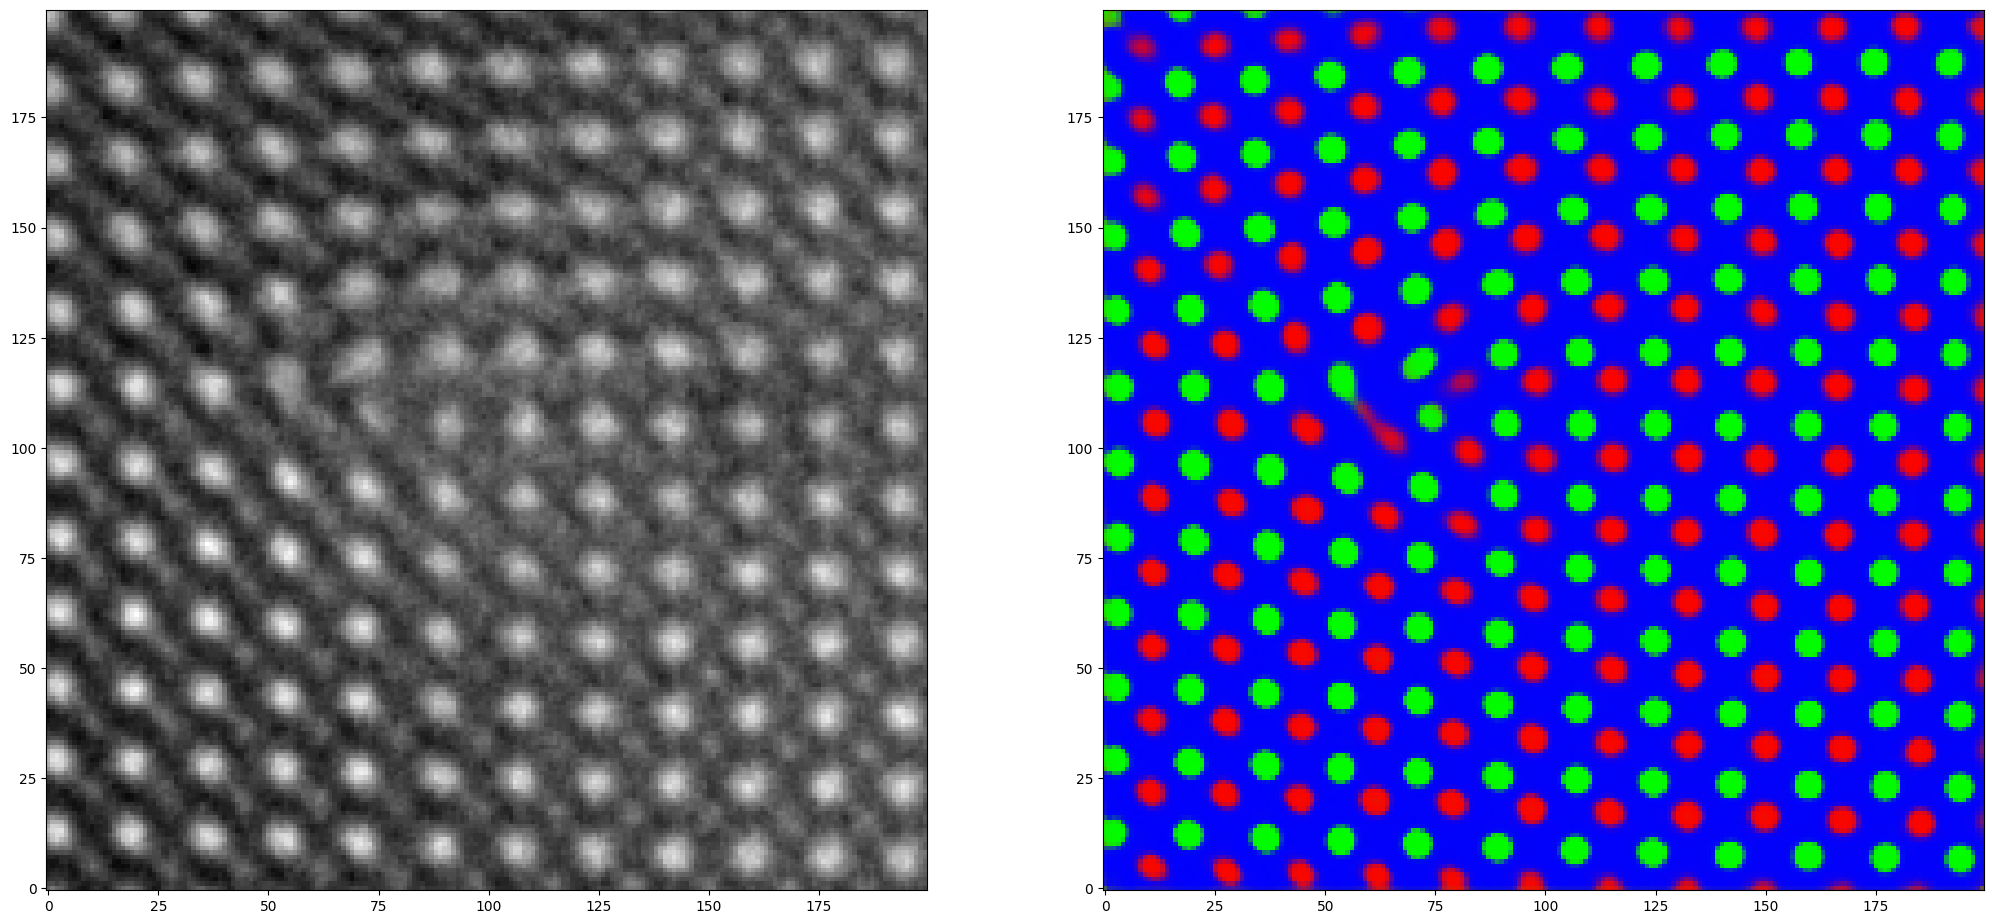

In [10]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
ax1.imshow(expdata, cmap='gray', origin="lower")
ax2.imshow(nn_output.squeeze(), origin="lower")

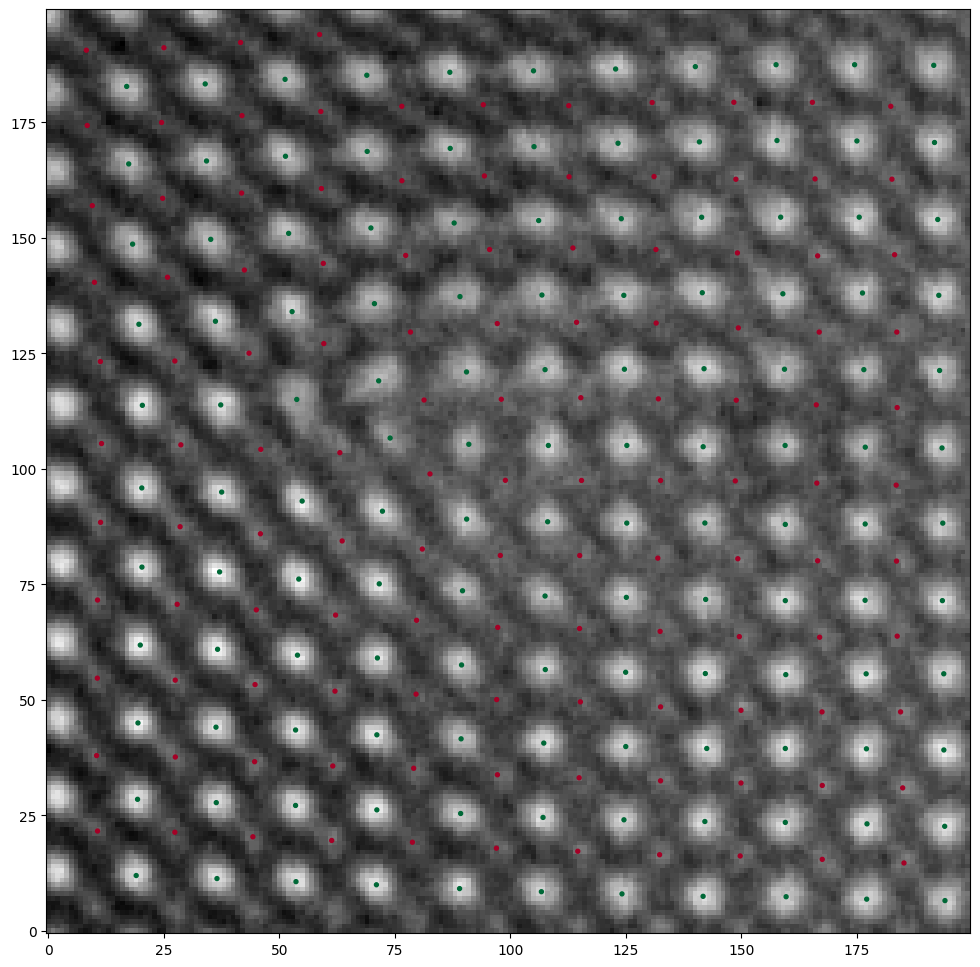

In [11]:
aoi.utils.plot_coord(expdata, coordinates[0], fsize=12)

##PCA

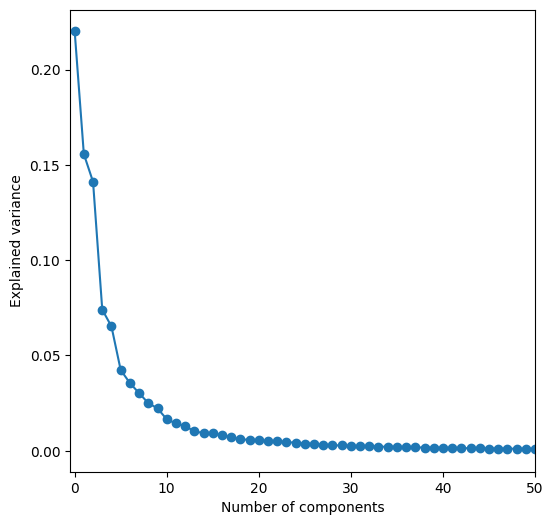

In [12]:
imstack = aoi.stat.imlocal(nn_output, coordinates, window_size=32, coord_class=1)
imstack.pca_scree_plot(plot_results=True);

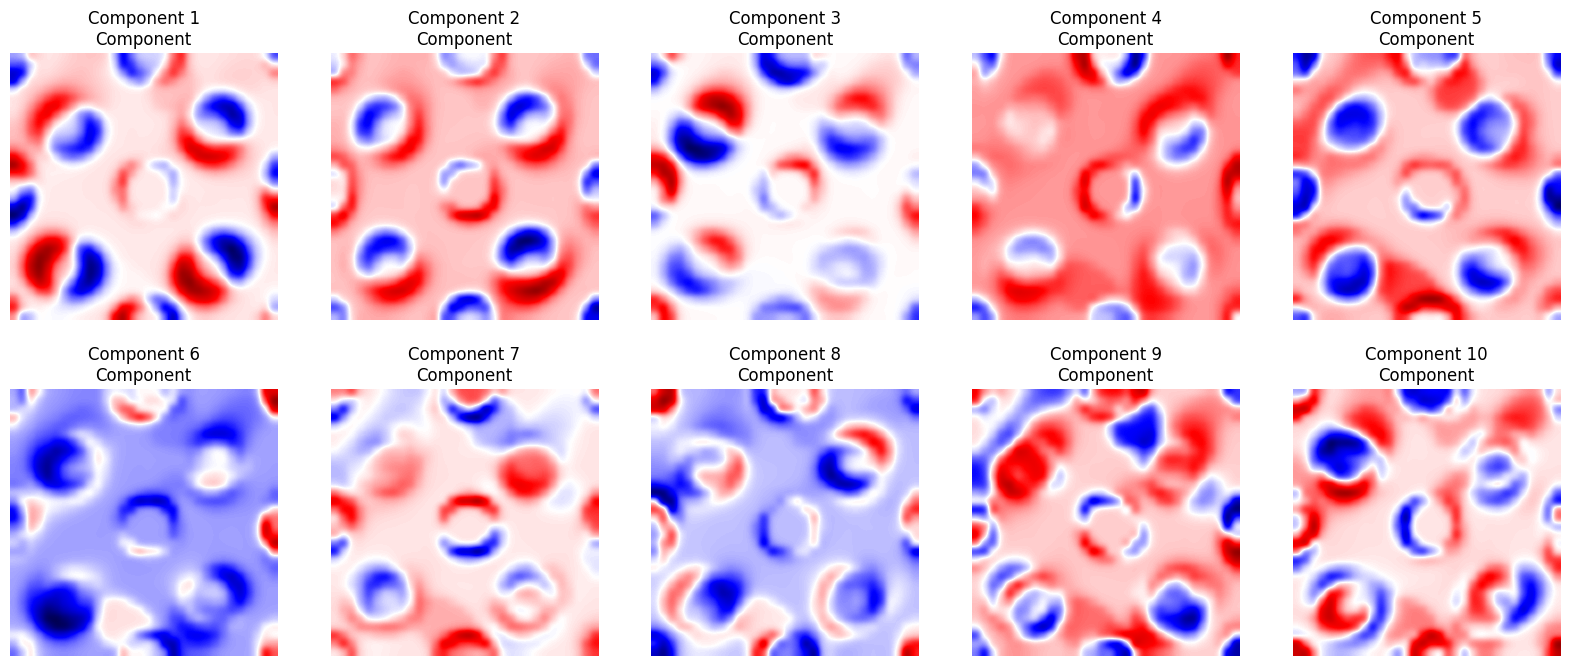

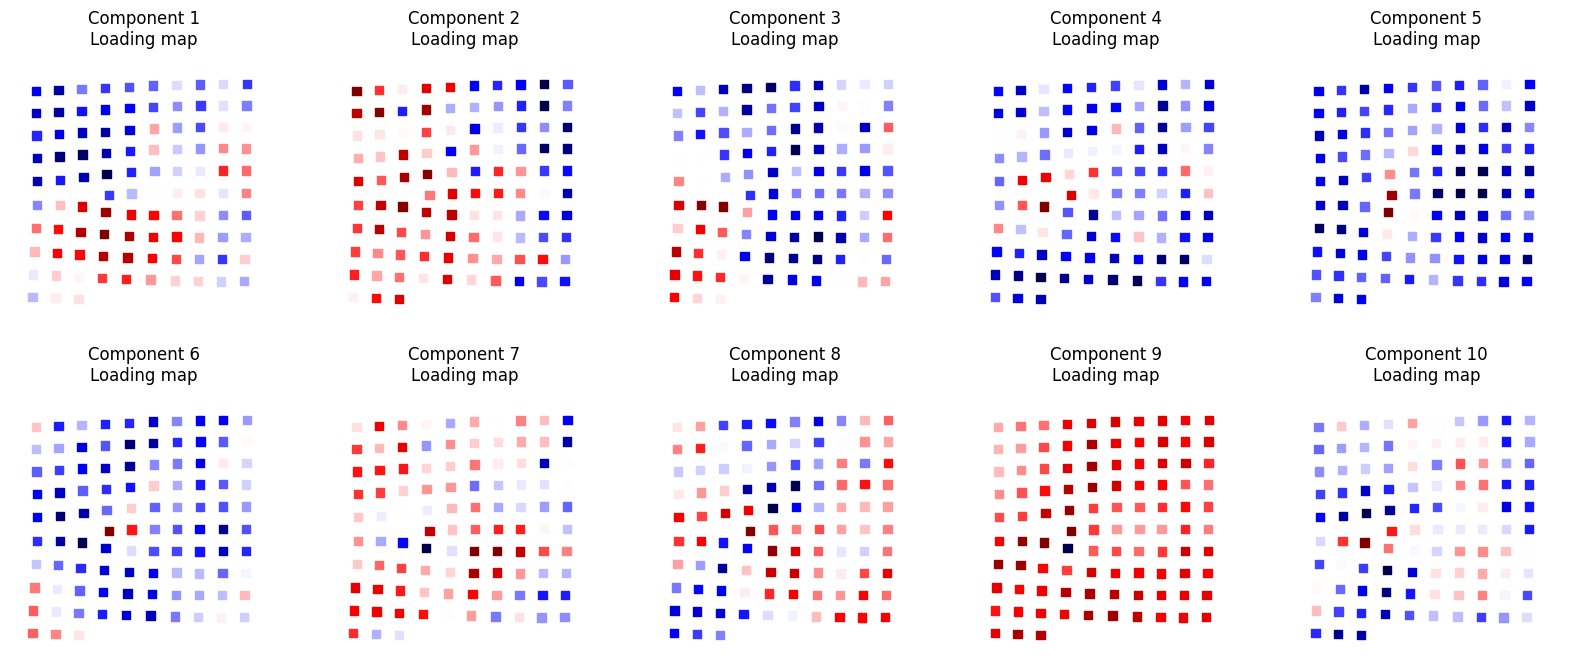

In [13]:
pca_results = imstack.imblock_pca(10, plot_results=True)

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


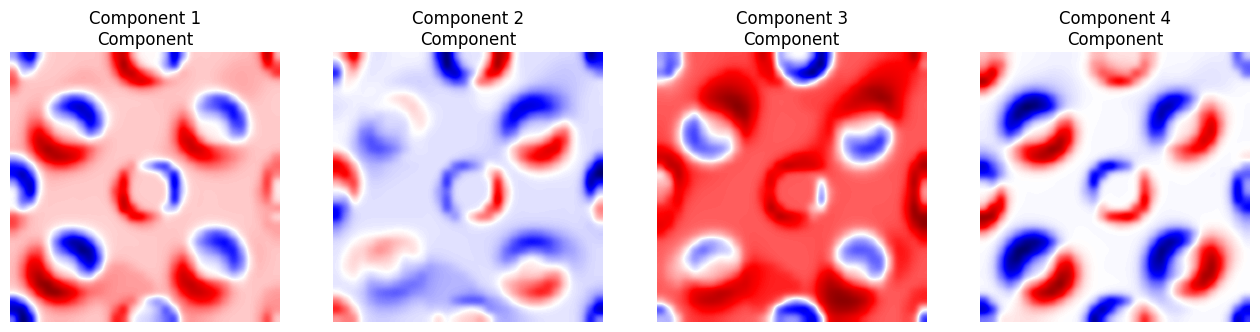

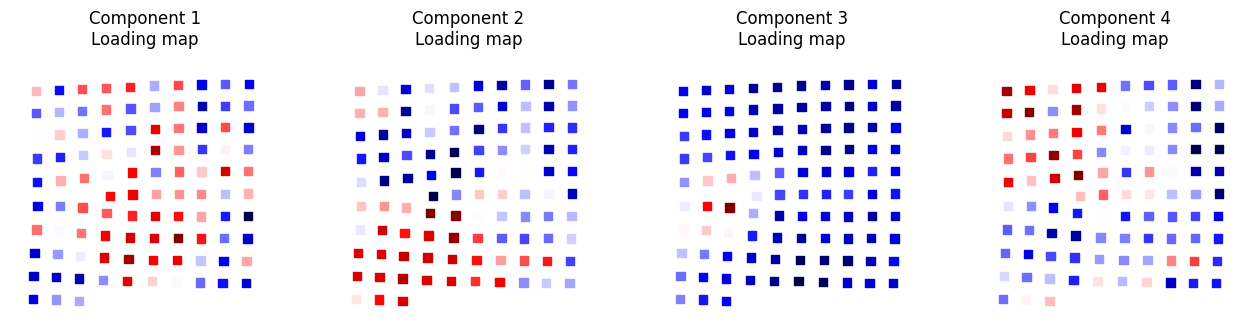

In [14]:
ica_results = imstack.imblock_ica(4, plot_results=True)

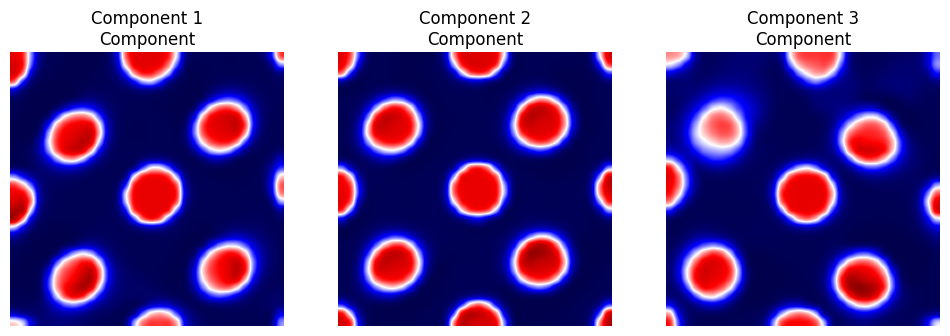

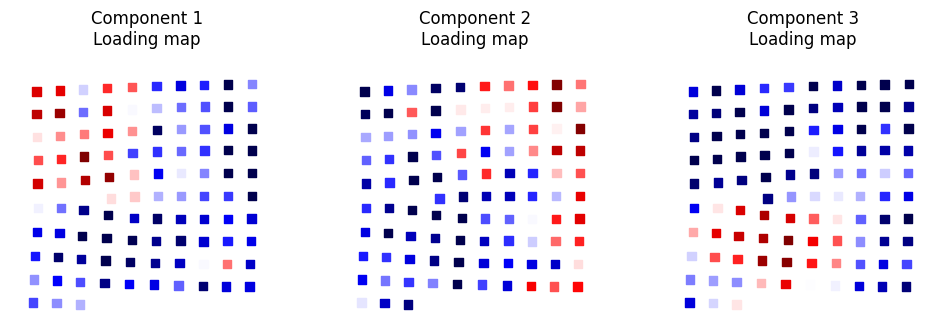

In [15]:
nmf_results = imstack.imblock_nmf(3, plot_results=True)

##Training Dataset Generation

In [16]:
from atomai.utils import create_lattice_mask, extract_patches_
from atomai.transforms import datatransform
import numpy as np
import matplotlib.pyplot as plt

In [17]:
download_link = 'https://drive.google.com/uc?id=1_uo7BXjDU-laUAs4Uj1aFqwqfnxi9tpz'
!gdown $download_link -O 'img_w_coord.npy'
img_w_coord = np.load('img_w_coord.npy')
lattice_im = img_w_coord['lattice_img']
xy_atoms_a = img_w_coord['lattice_coord_a']
xy_atoms_b = img_w_coord['lattice_coord_b']
print(lattice_im.shape, xy_atoms_a.shape, xy_atoms_b.shape)

Downloading...
From (original): https://drive.google.com/uc?id=1_uo7BXjDU-laUAs4Uj1aFqwqfnxi9tpz
From (redirected): https://drive.google.com/uc?id=1_uo7BXjDU-laUAs4Uj1aFqwqfnxi9tpz&confirm=t&uuid=7fd33329-92a7-4513-853e-a1aba5353e6e
To: /content/img_w_coord.npy
100% 118M/118M [00:01<00:00, 71.4MB/s]
(3801, 3801) (2, 64932) (2, 65465)


In [18]:
lattice_mask_a = create_lattice_mask(lattice_im, xy_atoms_a.T)
lattice_mask_b = create_lattice_mask(lattice_im, xy_atoms_b.T)

multiclass = True

if multiclass:
    lattice_mask_backgr = 1 - (lattice_mask_a + lattice_mask_b)
    lattice_mask = np.concatenate(
        (lattice_mask_a[..., None],
         lattice_mask_b[..., None],
         lattice_mask_backgr[..., None]), # we need to add a background class
        axis=-1)
else:
    lattice_mask = lattice_mask_a + lattice_mask_b
    lattice_mask[lattice_mask>1] = 1

In [19]:
images_all, labels_all = extract_patches_(
    lattice_im, lattice_mask, patch_size=200, num_patches=999, random_state=42)
print(images_all.shape, labels_all.shape)

(999, 200, 200) (999, 200, 200, 3)


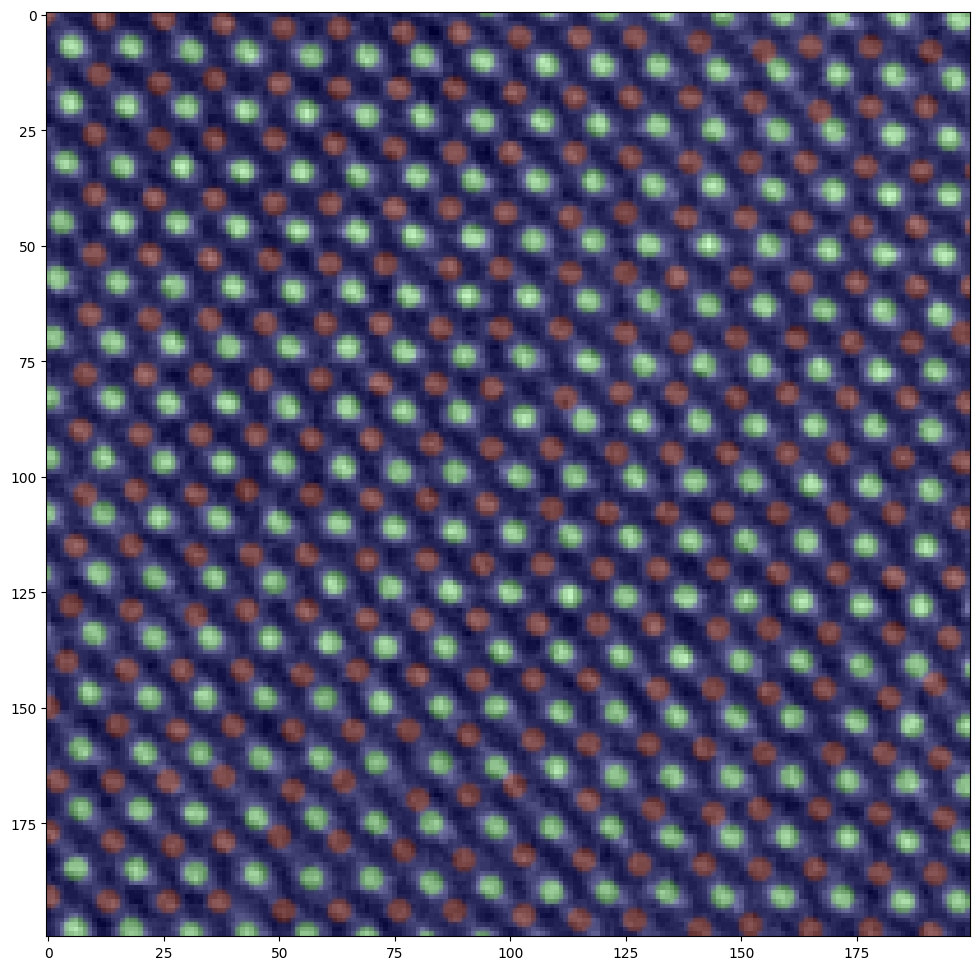

In [20]:
k = 101
plt.figure(figsize=(12, 12), dpi=100)
plt.imshow(images_all[k], cmap='gray')
plt.imshow(labels_all[k], alpha=.2, interpolation='Gaussian')

In [21]:
labels_all = np.concatenate([labels_all, nn_output], axis=0)
loc = aoi.predictors.Locator()
coord = loc.run(labels_all)

##VAE

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import atomai as aoi

In [23]:
window_size = 24
s = aoi.stat.imlocal(
    np.sum(labels_all[..., :-1], -1)[..., None], # convert to a single channel (no background)
    coord, window_size, 0)


GMM components


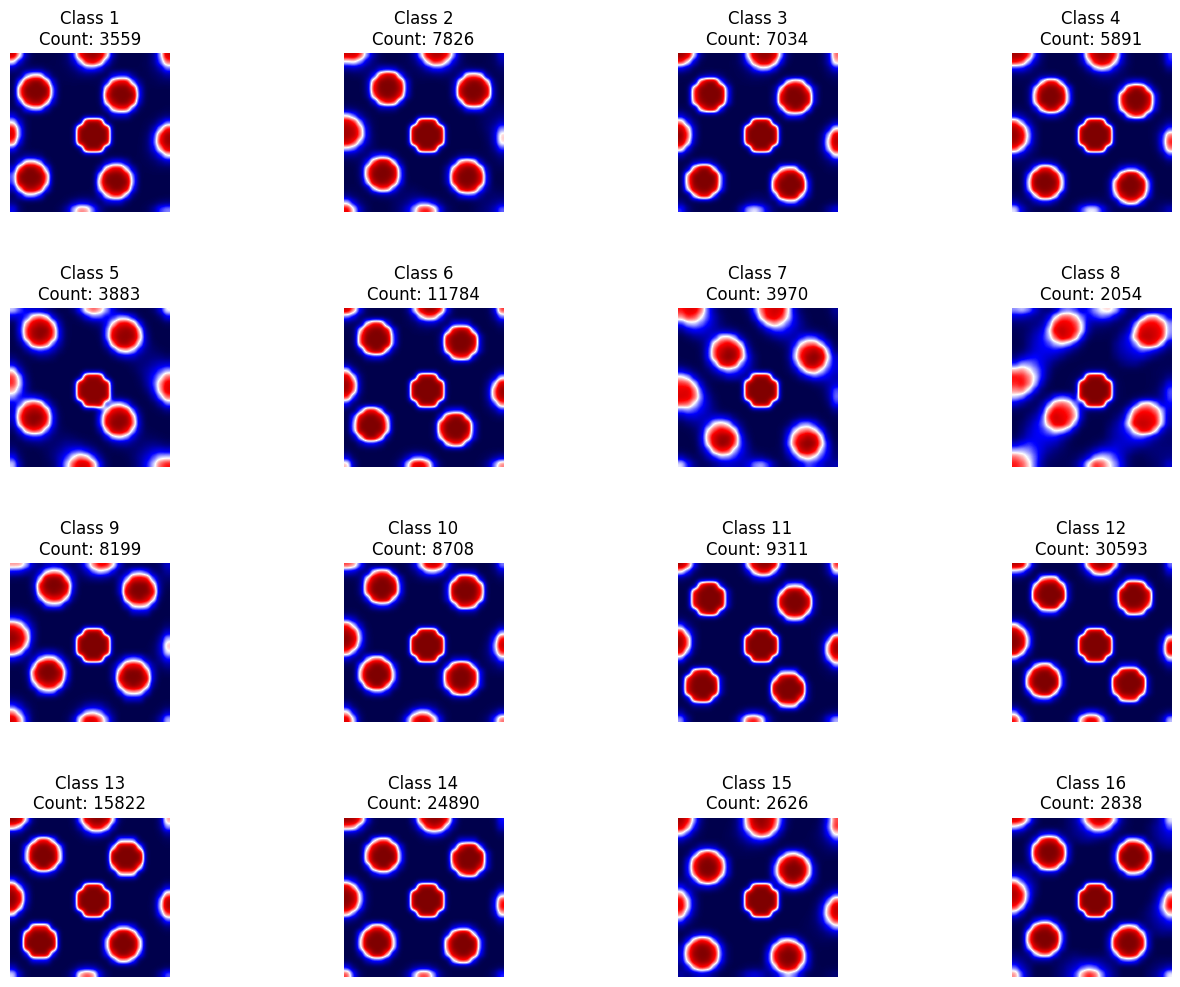

In [24]:
s.gmm(n_components=16, plot_results=True, random_state=42);

In [25]:
imstack = s.imgstack[..., 0] # will be used as training/test data
frames_all = s.imgstack_frames # will need for plotting VAE results
com_all = s.imgstack_com # will need for plotting VAE results

from sklearn.model_selection import train_test_split
imstack_train, imstack_test = train_test_split(
    imstack, test_size=0.15, shuffle=True, random_state=0)
print(imstack_train.shape, imstack_test.shape)

(126639, 24, 24) (22349, 24, 24)


In [26]:
# Ititialize model
in_dim = (window_size, window_size)
vae = aoi.models.VAE(in_dim)
# Train
vae.fit(X_train=imstack_train, X_test=imstack_test, training_cycles=200, batch_size=200)

Epoch: 1/200, Training loss: 25.8623, Test loss: 18.4031
Epoch: 2/200, Training loss: 17.5667, Test loss: 16.9442
Epoch: 3/200, Training loss: 16.4604, Test loss: 16.2074
Epoch: 4/200, Training loss: 15.9335, Test loss: 15.8082
Epoch: 5/200, Training loss: 15.6028, Test loss: 15.5528
Epoch: 6/200, Training loss: 15.3786, Test loss: 15.3337
Epoch: 7/200, Training loss: 15.1946, Test loss: 15.1617
Epoch: 8/200, Training loss: 15.0491, Test loss: 15.0280
Epoch: 9/200, Training loss: 14.9282, Test loss: 14.9052
Epoch: 10/200, Training loss: 14.8180, Test loss: 14.7993
Epoch: 11/200, Training loss: 14.7194, Test loss: 14.7247
Epoch: 12/200, Training loss: 14.6396, Test loss: 14.6294
Epoch: 13/200, Training loss: 14.5652, Test loss: 14.5660
Epoch: 14/200, Training loss: 14.5087, Test loss: 14.5470
Epoch: 15/200, Training loss: 14.4580, Test loss: 14.4749
Epoch: 16/200, Training loss: 14.4033, Test loss: 14.4305
Epoch: 17/200, Training loss: 14.3686, Test loss: 14.3965
Epoch: 18/200, Training

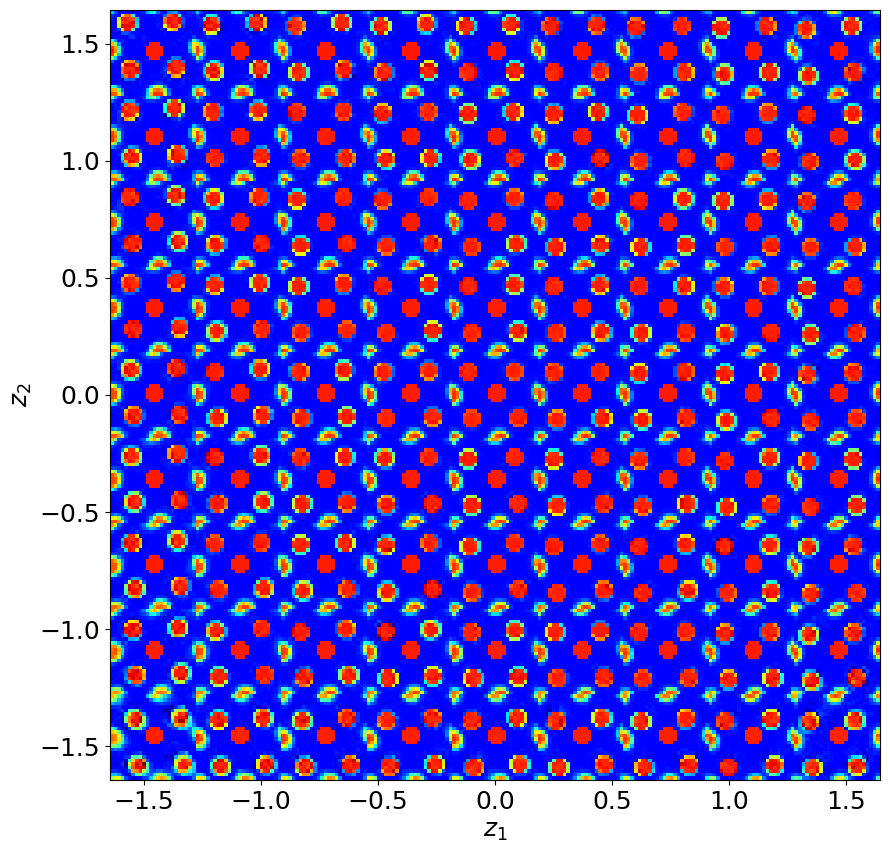

In [27]:
vae.manifold2d(cmap="jet");

In [28]:
# Ititialize model
in_dim = (window_size, window_size)
rvae = aoi.models.rVAE(in_dim)
# Train
rvae.fit(X_train=imstack_train, X_test=imstack_test, training_cycles=200, batch_size=200)

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: 1/200, Training loss: 53.2956, Test loss: 52.0407
Epoch: 2/200, Training loss: 51.8366, Test loss: 51.7286
Epoch: 3/200, Training loss: 51.3325, Test loss: 51.0347
Epoch: 4/200, Training loss: 50.8703, Test loss: 50.7674
Epoch: 5/200, Training loss: 50.4883, Test loss: 49.5579
Epoch: 6/200, Training loss: 47.1286, Test loss: 43.4814
Epoch: 7/200, Training loss: 41.9805, Test loss: 41.2469
Epoch: 8/200, Training loss: 40.4532, Test loss: 39.7274
Epoch: 9/200, Training loss: 36.9578, Test loss: 32.1120
Epoch: 10/200, Training loss: 30.1238, Test loss: 29.0360
Epoch: 11/200, Training loss: 28.0295, Test loss: 27.1013
Epoch: 12/200, Training loss: 26.1660, Test loss: 25.4198
Epoch: 13/200, Training loss: 24.8722, Test loss: 24.4822
Epoch: 14/200, Training loss: 24.1317, Test loss: 23.9073
Epoch: 15/200, Training loss: 23.6422, Test loss: 23.4991
Epoch: 16/200, Training loss: 23.2950, Test loss: 23.2152
Epoch: 17/200, Training loss: 23.0581, Test loss: 23.0097
Epoch: 18/200, Training

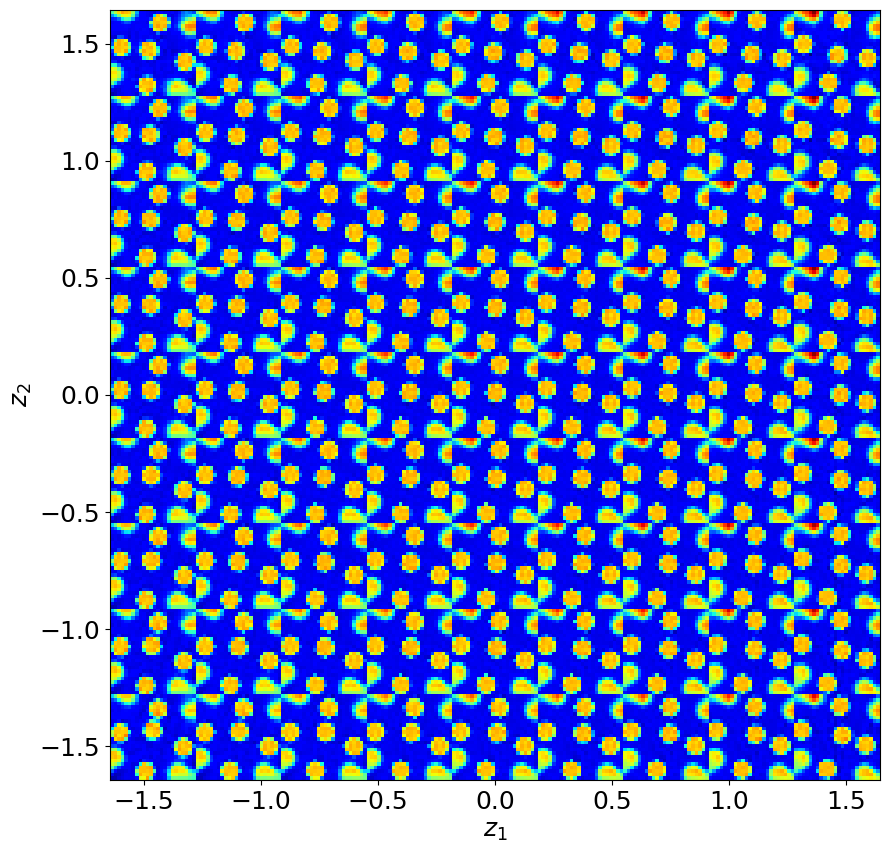

In [29]:
rvae.manifold2d(cmap="jet");

In [32]:
z_mean, z_sd = rvae.encode(imstack)
z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]

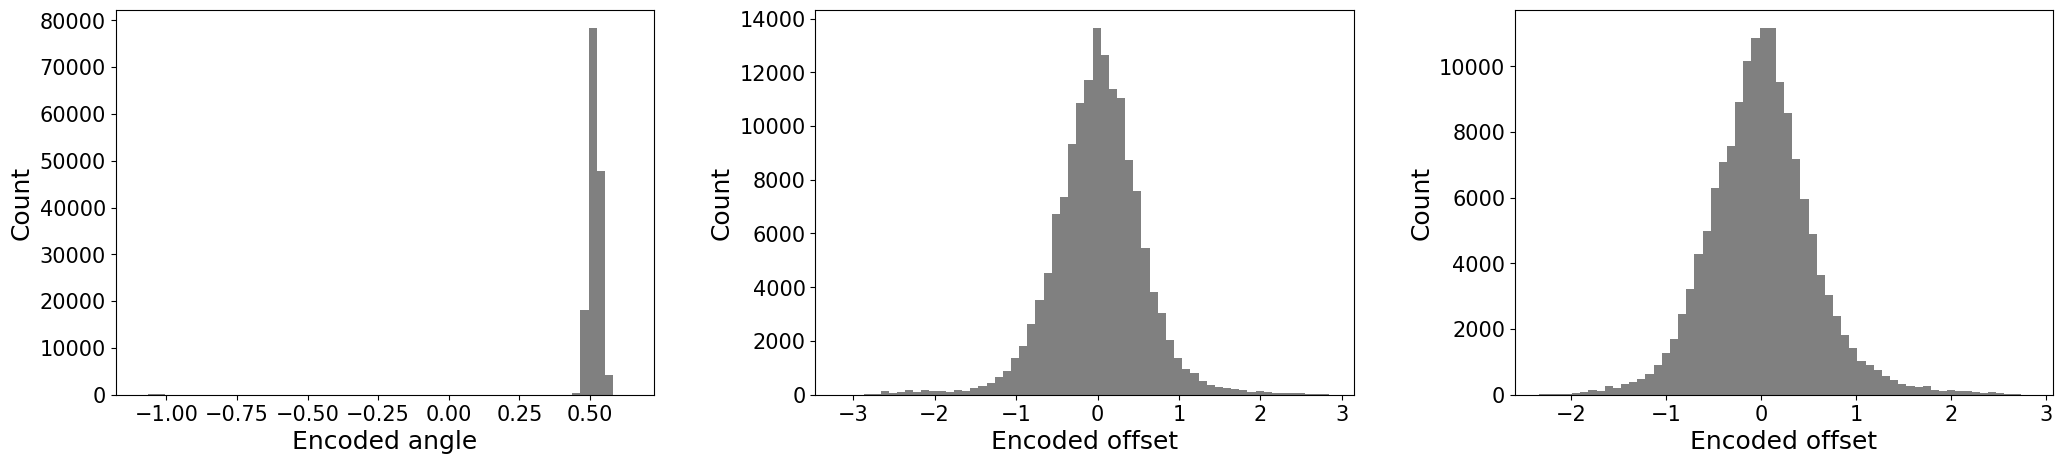

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(z1, bins=60, color='gray')
ax[1].hist(z2[:, 0], bins=60, color='gray')
ax[2].hist(z2[:, 1], bins=60, color='gray')
ax[0].set_xlabel("Encoded angle", fontsize=18)
ax[1].set_xlabel("Encoded offset", fontsize=18)
ax[2].set_xlabel("Encoded offset", fontsize=18)
for _ax in fig.axes:
    _ax.set_ylabel("Count", fontsize=18)
    _ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

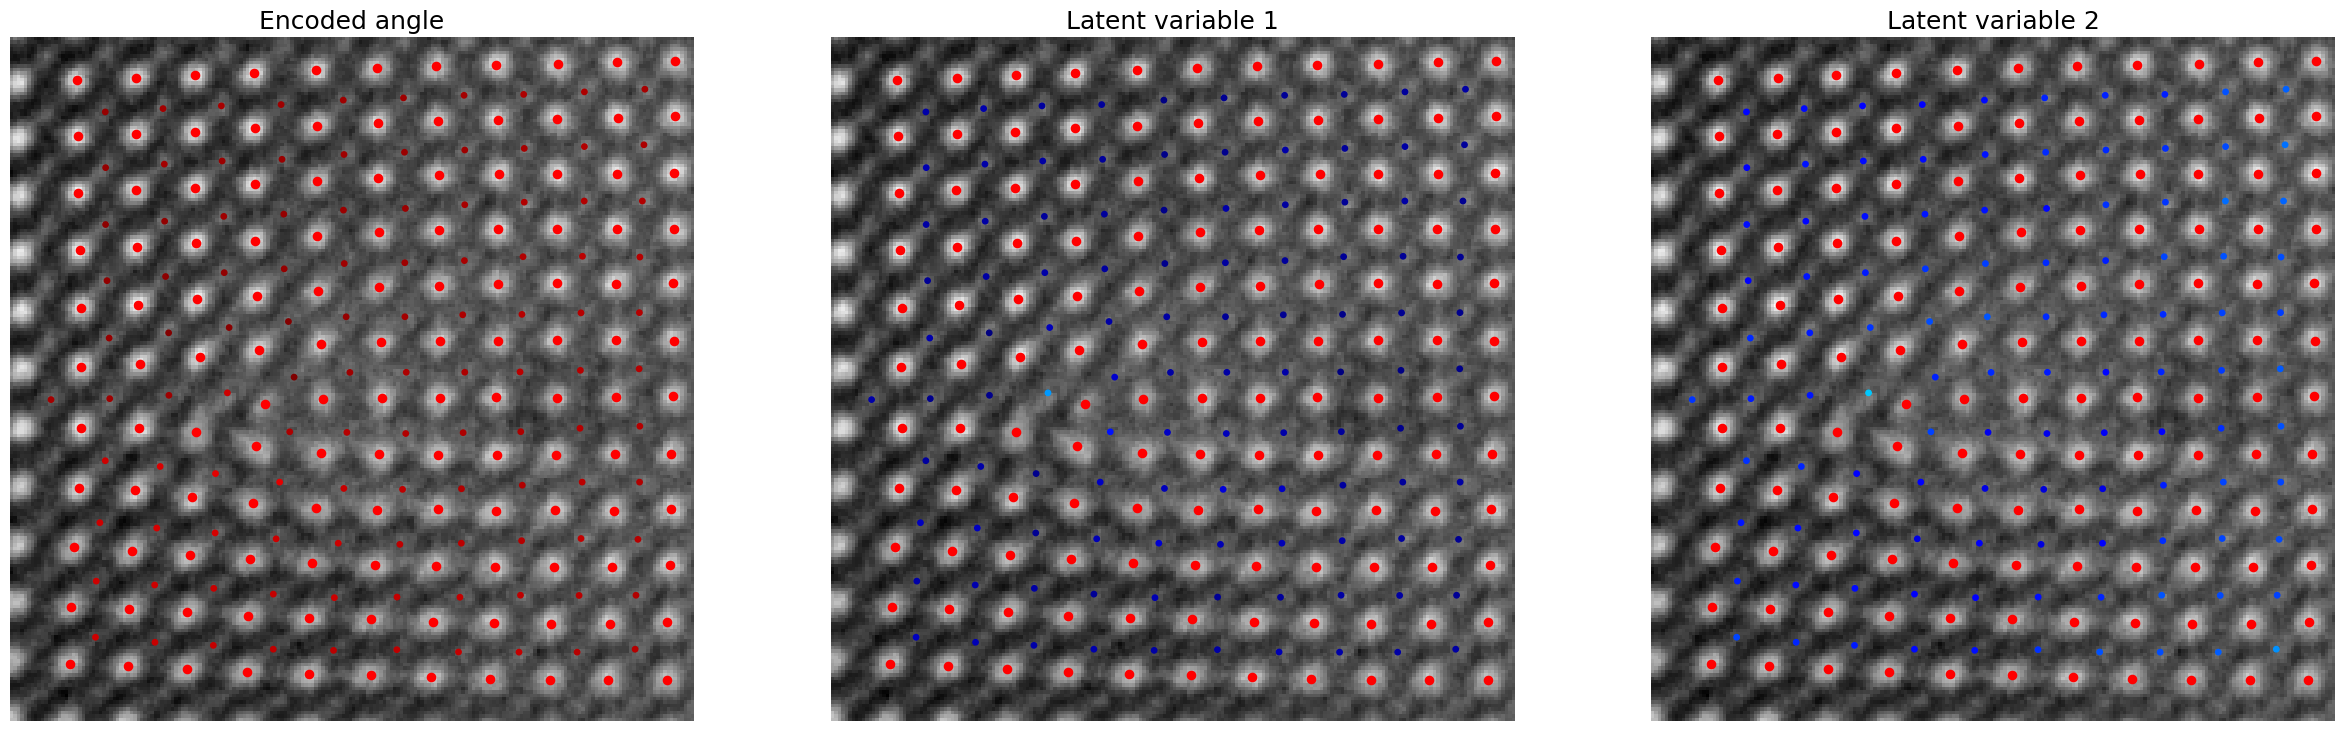

In [42]:
frame = 999 # select frame

com_i = com_all[frames_all == frame] # get coordinates for this frame
com_i_Si = coord[frame] # get Si coordinates for plotting
com_i_Si = com_i_Si[com_i_Si[:,-1]==1.]
z1_i = z1[frames_all == frame] # get latent variables (image) for this frame
z3_i = z3[frames_all == frame] # get latent variables (image) for this frame

col_min0 = z1.min()
col_max0 = z1.max()
col_min1 = z3[:, 0].min()
col_max1 = z3[:, 0].max()
col_min2 = z3[:, 1].min()
col_max2 = z3[:, 1].max()

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
# ax[0].imshow(images_all[frame,...], cmap="gray")
# ax[0].scatter(com_i[:, 1], com_i[:, 0], c=z1_i, s=15,
#             cmap="jet", vmin=col_min0, vmax=col_max0)
# ax[0].set_title("Encoded angle", fontsize=18)
# ax[1].imshow(images_all[frame,...], cmap="gray")
# ax[1].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 0], s=15,
#             cmap="jet", vmin=col_min1, vmax=col_max1)
# ax[1].set_title("Latent variable 1", fontsize=18)
# ax[2].imshow(images_all[frame,...], cmap="gray")
# ax[2].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 1], s=15,
#               cmap="jet", vmin=col_min2, vmax=col_max2)
# ax[2].set_title("Latent variable 2", fontsize=18)

ax[0].imshow(expdata, cmap="gray")
ax[0].scatter(com_i[:, 1], com_i[:, 0], c=z1_i, s=15,
            cmap="jet", vmin=col_min0, vmax=col_max0)
ax[0].set_title("Encoded angle", fontsize=18)
ax[1].imshow(expdata, cmap="gray")
ax[1].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 0], s=15,
            cmap="jet", vmin=col_min1, vmax=col_max1)
ax[1].set_title("Latent variable 1", fontsize=18)
ax[2].imshow(expdata, cmap="gray")
ax[2].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 1], s=15,
              cmap="jet", vmin=col_min2, vmax=col_max2)
ax[2].set_title("Latent variable 2", fontsize=18)
for _ax in fig.axes:
    _ax.scatter(com_i_Si[:, 1], com_i_Si[:, 0], s=35, c='Red')
    _ax.axis(False)
plt.show()